# Name: Muhammad Hamza
## CMS ID: 407251
## Assignment: 03
## Date: 22/12/2024

## Information: (Facebook Social Circles Dataset)

- Nodes: Individuals
- Edges: Friendships & Interactions between them


## Task:
- Implement Spectral Clustering Algorithm
- Group individuals into clusters based on their connectivity
- You may need to create the similarity graph and Laplacian matrix
- Analyze the clusters to reveal underlying community structures and interpret social dynamics

## Setup the Environment

In [1]:
!pip install scikit-learn pandas numpy==1.24.0 matplotlib --quiet
!pip install networkx node2vec --quiet

In [2]:
import networkx as nx
import numpy as np
from networkx.algorithms import approximation
from networkx.algorithms import reciprocity
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby
from node2vec import Node2Vec
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import statistics

%matplotlib inline


/Users/truid/Desktop/Projects/MLAssignment/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reusable functions

In [52]:
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh


def loadGraph(file: str, plot: bool = True):
    G = nx.read_edgelist(file, create_using=nx.Graph(), nodetype=int)

    if plot:
        pos = nx.spring_layout(G)
        betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
        node_color = [20000.0 * G.degree(v) for v in G]
        node_size = [v * 10000 for v in betCent.values()]
        plt.figure(figsize=(12, 12))
        nx.draw_networkx(
            G, 
            pos=pos, 
            with_labels=False, 
            node_color=node_color, 
            node_size=node_size,
        )
        plt.axis("off")
        plt.show()

    return G

def plotWithClusters(G, clusters):
    pos = nx.spring_layout(G)
    betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
    node_size = [v * 10000 for v in betCent.values()]

    plt.figure(figsize=(12, 12))
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_color=clusters,
        node_size=node_size,
    )
    plt.axis("off")
    plt.show()

def eigenDecomposition(adjacency_matrix: np.ndarray, plot = True, top_k=5) -> tuple[int, np.ndarray, np.ndarray]:
    L = csgraph.laplacian(adjacency_matrix, normed=True)
    n_components = adjacency_matrix.shape[0]

    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="SM")

    if plot:
        plt.figure(figsize=(10, 5))
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.title("Eigenvalues of the Laplacian")
        plt.xlabel("Index")
        plt.ylabel("Eigenvalue")
        plt.grid()
        plt.show()
    
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::][:top_k]
    nb_clusters = index_largest_gap + 1
    return nb_clusters, eigenvalues, eigenvectors

## Read the Dataset

In [53]:
# import os

# # read the edge list
# edge_lists = []
# graphs = []
# adjacency_matrices = []
# for file in os.listdir('dataset'):
#     if file.endswith('.edges'):
#         edge_lists.append(nx.read_edgelist(f'dataset/{file}'))

#         G = nx.Graph()
#         G.add_edges_from(edge_lists[-1].edges())
#         graphs.append(G)

#         adjacency_matrices.append(nx.adjacency_matrix(G).todense())

# print(f'Loaded {len(graphs)} graphs')

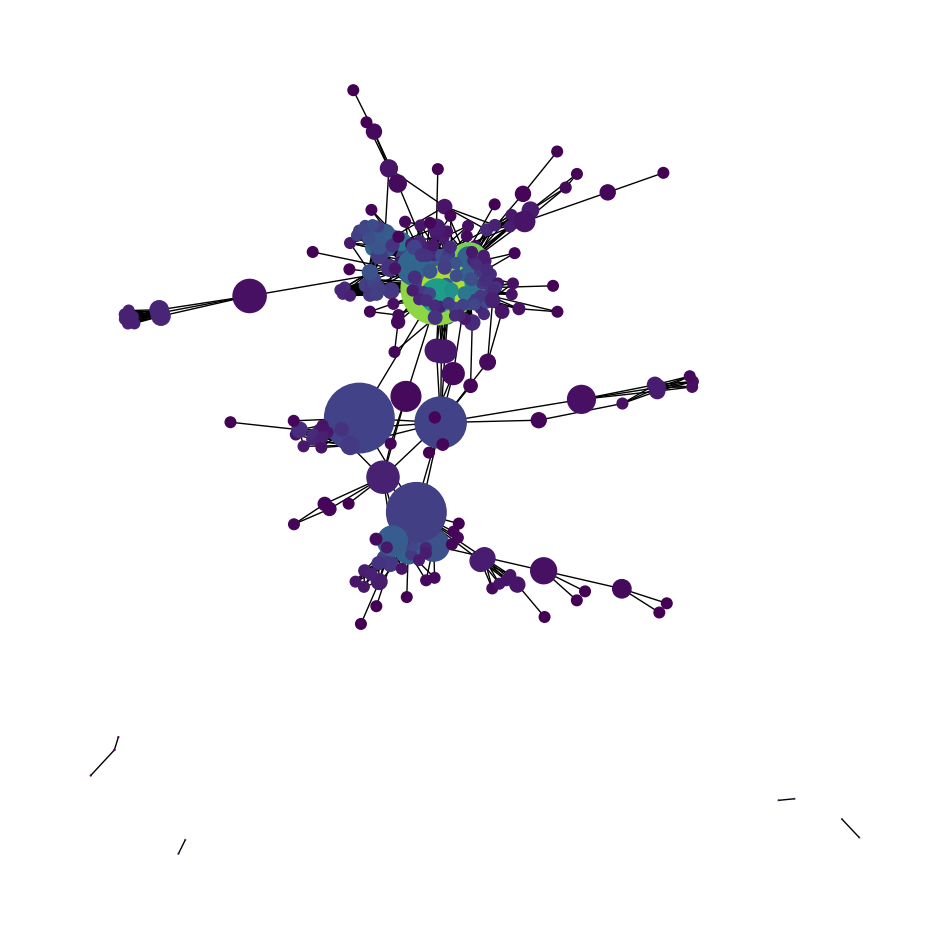

In [54]:
G0 = loadGraph('dataset/0.edges')

## Implement Spectral Clustering Algorithm

### Eigenvalues and Eigenvectors of the Laplacian Matrix

/var/folders/wh/4tzchpcn5dq93r99m5_wdv880000gn/T/ipykernel_92314/1747423378.py:46: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = eigsh(L, k=n_components, which="SM")


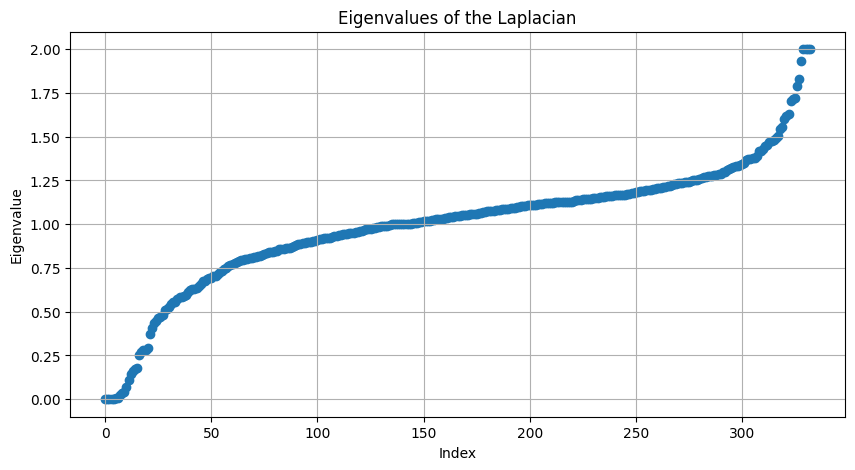

array([217,   4, 137, 139, 141])

In [55]:
adjacency_matrix = nx.adjacency_matrix(G0).todense()
nb_clusters, eigenvalues, eigenvectors = eigenDecomposition(adjacency_matrix)

nb_clusters

### K-means Clustering

In [56]:
# select the eigenvectors corresponding to the smallest eigenvalues
kmeans = KMeans(n_clusters=len(nb_clusters), random_state=42)
kmeans.fit(eigenvectors)
clusters = kmeans.predict(eigenvectors)
np.unique(clusters)

array([0, 1, 2, 3, 4], dtype=int32)

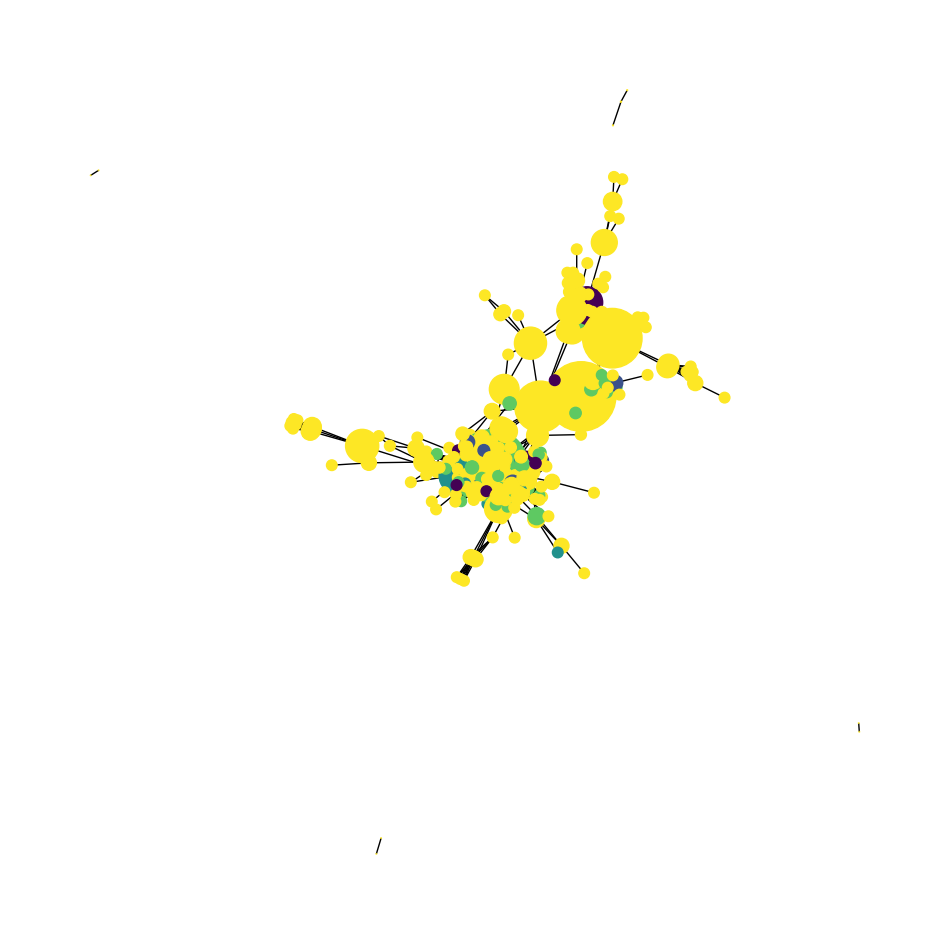

In [57]:
plotWithClusters(G0, clusters)